In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split

from causalml.inference.meta import BaseTRegressor
from causalml.metrics import auuc_score, qini_score

import xgboost as xgb

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import torch
import torch.nn as nn
import torch.optim as optim

/home/thebscotte/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Media Mix Modeling (MMM)

In [2]:
#Define function for channel activity
def spend_data(n, cut=.9):
    spend = np.random.uniform(0, 1, n)
    return np.where(spend > cut, spend, spend / 2)

#Define function for saturation link 
def saturation_link(x, a=1, b=.1, n_slope=1):
    return (a * x**n_slope) / (b**n_slope + x**n_slope)

#Define function for carryover link
def carryover_link(x, k=.3, l=7):
    w = np.array([np.power(k, i) for i in range(l)])
    xx = np.vstack([np.append(np.zeros(i), x[:len(x)-i]) for i in range(l)])
    y = np.dot(w / np.sum(w), xx)
    
    return y

#Define function for saturation and carryover 
def sat_w_carry_link(x, a, b, k, l):
    sat = saturation_link(x, a, b)
    
    return carryover_link(sat, k, l)

#Define function for generating mmm data
def gen_mmm_data(num_channels, l):
    min_date = pd.to_datetime('2024-01-01')
    max_date = pd.to_datetime('2024-12-31')
    beta_true = np.array([3, 6, 9])
    a_true = np.array([1, 2, 3])
    b_true = np.array([.25, .45, .65])
    k_true = np.array([.2, .3, .4])
    baseline = 8
    
    df = pd.DataFrame(index=pd.date_range(min_date, max_date, freq='W'))
    
    
    raw_activity = [spend_data(df.shape[0], ) for i, j in zip(range(num_channels), [.9,.8, .7])]
    link_activity = [sat_w_carry_link(raw_activity[i], a_true[i], b_true[i], k_true[i], l) for i in range(num_channels)]
    
    for i in range(num_channels):
        df[f'channel_{i+1}'] = raw_activity[i]
        df[f'channel_{i+1}_link'] = link_activity[i]
        
        
    df['noise'] = .2 * np.random.uniform(-1, 1, df.shape[0])
    df['ticket_size'] = baseline + np.dot(np.array(link_activity).T, beta_true) + df['noise'].values
    
    return df

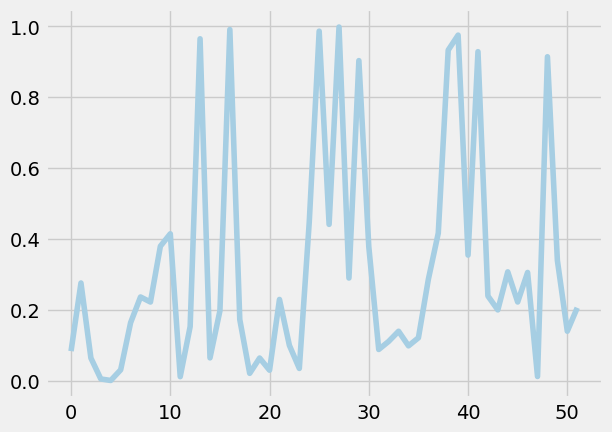

In [3]:
#Plot spend
t_s = spend_data(52)
plt.plot(t_s)

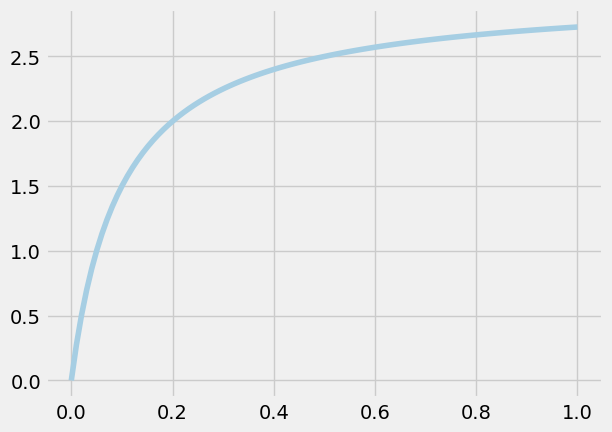

In [4]:
#Plot saturation
plt.plot(np.linspace(0,1,100), saturation_link(np.linspace(0,1,100),a=3))

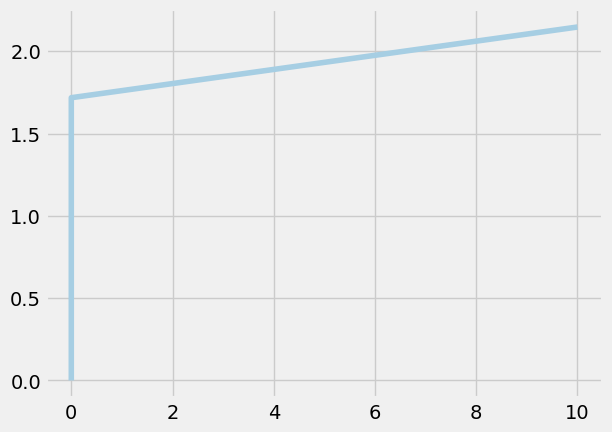

In [5]:
#Plot carryover
x_t = np.zeros(100)
x_t[0] = 10
plt.plot(x_t, carryover_link(x_t, k=.8, l=12))

In [6]:
#Generate synthetic data
temp_df = gen_mmm_data(3, 2)

In [7]:
temp_df

,channel_1,channel_1_link,channel_2,channel_2_link,channel_3,channel_3_link,noise,ticket_size
2024-01-07,0.313123,0.463373,0.182564,0.444015,0.986273,1.291620,0.093320,23.772107
2024-01-14,0.130625,0.378663,0.156092,0.529417,0.181175,0.983735,-0.097775,21.068333
2024-01-21,0.137517,0.352920,0.057482,0.293123,0.380882,0.978560,-0.122185,19.502355
2024-01-28,0.179916,0.407887,0.346990,0.722087,0.376330,1.102422,-0.180355,23.297628
2024-02-04,0.313146,0.533136,0.289682,0.803451,0.160485,0.738601,0.116493,21.184021
2024-02-11,0.276677,0.530449,0.213372,0.675596,0.151015,0.573715,-0.025053,18.783303
2024-02-18,0.221230,0.478783,0.945779,1.190913,0.266757,0.785124,0.164530,23.812473
2024-02-25,0.062295,0.244474,0.928521,1.348989,0.298862,0.924344,0.107690,25.254140
2024-03-03,0.190831,0.393987,0.324362,0.955301,0.411435,1.100590,0.004299,24.823375
2024-03-10,0.405585,0.587699,0.100335,0.473814,0.988796,1.625177,0.023074,27.255650


In [8]:
#Keep necessary columns for modeling
temp_df = temp_df.drop(['channel_1_link', 'channel_2_link', 'channel_3_link', 'noise'], axis=1)

In [9]:
#Define functions for bayesian mmm links
def jax_saturation_link(x, a=1, b=.1, n_slope=1):
    return (a * x**n_slope) / (b**n_slope + x**n_slope)

#Define function for carryover link
def jax_carryover_link(x, k=.3, l=2):
    w = jnp.array([jnp.power(k, i) for i in range(l)])
    xx = jnp.vstack([jnp.append(jnp.zeros(i), x[:len(x)-i]) for i in range(l)])
    y = jnp.dot(w / jnp.sum(w), xx)
    
    return y

In [10]:
#Define function for bayesian mmm
def bayes_mmm_orders(X_vars, y_vars=None):
    baseline = numpyro.sample('baseline', dist.Normal(5, 5))
    beta = numpyro.sample('beta', dist.Normal(5,3).expand([X_vars.shape[1]]))
    alpha = numpyro.sample('alpha', dist.Gamma(3, 2).expand([X_vars.shape[1]]))
    b = numpyro.sample('b', dist.Beta(2, 2).expand([X_vars.shape[1]]))
    gamma = numpyro.sample('gamma', dist.Beta(2, 2).expand([X_vars.shape[1]]))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    
    X_vars_sat = jax_saturation_link(X_vars, alpha, b)
    X_vars_link = jnp.array([jax_carryover_link(X_vars_sat[:,i], gamma[i]) for i in range(X_vars.shape[1])]).T
    
    mu = baseline + jnp.dot(X_vars_link, beta)
    
    with numpyro.plate("data", X_vars.shape[0]):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y_vars)

In [11]:
#Define and run MCMC
rng_key = random.PRNGKey(0)
kernel = NUTS(bayes_mmm_orders)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, temp_df.drop(['ticket_size'], axis=1).values, temp_df['ticket_size'].values)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|██████████████████████████| 3000/3000 [00:19<00:00, 156.91it/s, 511 steps of size 4.73e-03. acc. prob=0.91]


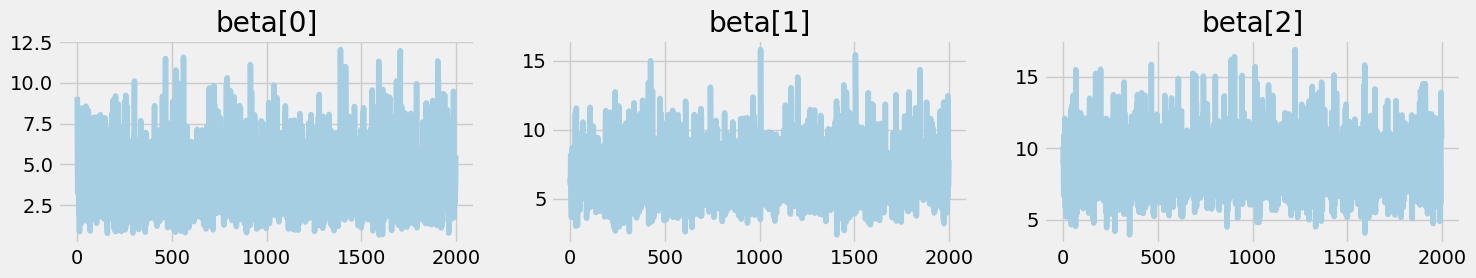

In [12]:
#Plot trace plots of betas
fig, ax = plt.subplots(1,3, figsize=(15,3))

for i, a in enumerate(ax.flatten()):
    a.plot(mcmc.get_samples()['beta'][:,i])
    a.set_title(f"beta[{i}]")
    
fig.tight_layout();

In [13]:
#View summary
print(mcmc.print_summary())


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]      1.02      0.59      0.87      0.27      1.75   1340.54      1.00
  alpha[1]      1.96      0.61      1.85      1.03      2.85   1767.24      1.00
  alpha[2]      3.16      0.75      3.06      1.92      4.26   1554.36      1.00
      b[0]      0.29      0.04      0.28      0.22      0.35   1693.80      1.00
      b[1]      0.48      0.02      0.48      0.45      0.52   1684.91      1.00
      b[2]      0.66      0.02      0.66      0.63      0.69   2184.57      1.00
  baseline      8.20      0.12      8.20      8.02      8.42   1493.97      1.00
   beta[0]      3.95      2.03      3.51      1.01      7.07   1215.27      1.00
   beta[1]      6.96      2.04      6.75      3.56     10.04   1685.56      1.00
   beta[2]      8.95      2.07      8.75      5.51     12.11   1329.96      1.00
  gamma[0]      0.16      0.03      0.16      0.11      0.22   2448.76      1.00
  gamma[1]      0.32      0

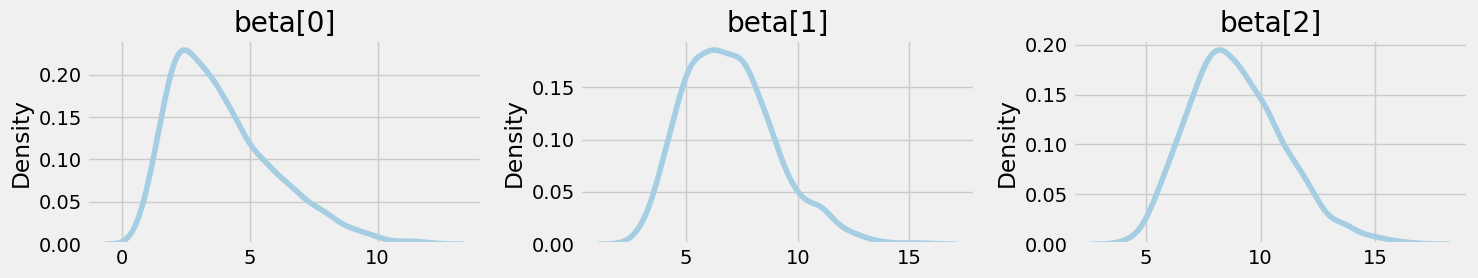

In [14]:
#View posterior densities
fig, ax = plt.subplots(1,3, figsize=(15,3))

for i, a in enumerate(ax.flatten()):
    sns.kdeplot(mcmc.get_samples()['beta'][:,i], ax=a)
    a.set_title(f"beta[{i}]")
    
fig.tight_layout();

# Uplift Causal Modeling

In [15]:
#Define function for uplift synthetic data
def generate_synthetic_uplift(n_samples=1000, random_seed=42):
    np.random.seed(random_seed)

    X = pd.DataFrame({
        'age': 18 + np.random.binomial(30, .3, n_samples),
        'last_order_days': np.random.randint(0, 30, n_samples),
        'loyalty_tier': np.random.choice(['bronze', 'silver', 'gold'], n_samples),
        'gender': np.random.choice(['Male', 'Female'], n_samples)
    })

    X = pd.get_dummies(X, columns=['loyalty_tier', 'gender'], drop_first=True)

    treatment_prob = 1 / (1 + np.exp(-(0.01 * X['age'] + 0.01 * X['last_order_days'] - 0.4 * X['loyalty_tier_silver'])))
    T = np.random.binomial(1, treatment_prob)

    U = 0.01 * X['age'] + 0.15 * X['last_order_days']  + 1.4 * X['loyalty_tier_silver'] + .1 * X['loyalty_tier_gold']

    baseline_outcome = 0.1 * X['age'] - 0.1 * X['last_order_days'] + 0.1 * X['loyalty_tier_silver'] + 0.5 * X['loyalty_tier_gold']
    Y = baseline_outcome + T * U + np.random.normal(0, 0.5, n_samples)

    data = pd.DataFrame({
        'treatment': T,
        'outcome': Y,
        'true_uplift': U
    })
    data = pd.concat([data, X], axis=1)

    return data

In [16]:
# Generate the dataset
synthetic_uplift = generate_synthetic_uplift()

# Display the first few rows
synthetic_uplift.head()

,treatment,outcome,true_uplift,age,last_order_days,loyalty_tier_gold,loyalty_tier_silver,gender_Male
0,1,3.129651,2.46,26,14,True,False,False
1,0,2.389504,3.36,31,11,False,True,False
2,0,0.794982,6.04,29,29,False,True,True
3,0,1.248120,3.93,28,15,False,True,True
4,0,-0.152519,5.09,24,23,False,True,False


In [17]:
#View average true uplift
synthetic_uplift['true_uplift'].mean()

2.98171

In [18]:
#Train test split
X = synthetic_uplift.drop(['outcome', 'true_uplift'], axis=1)
y = synthetic_uplift['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
#Instantiate model
base_t_xgb = BaseTRegressor(xgb.XGBRegressor())

In [20]:
#Fit model
base_t_xgb.fit(X_train.drop('treatment', axis=1), X_train['treatment'], y_train)

In [21]:
#Get ATE
print(f"ATE: {base_t_xgb.estimate_ate(X_test.drop('treatment', axis=1), X_test['treatment'], y_test)}")

ATE: (array([3.14011101]), array([2.9729837]), array([3.30723833]))


In [22]:
#Get uplift predictions
base_t_xgb_cate = base_t_xgb.predict(X_test.drop('treatment', axis=1))

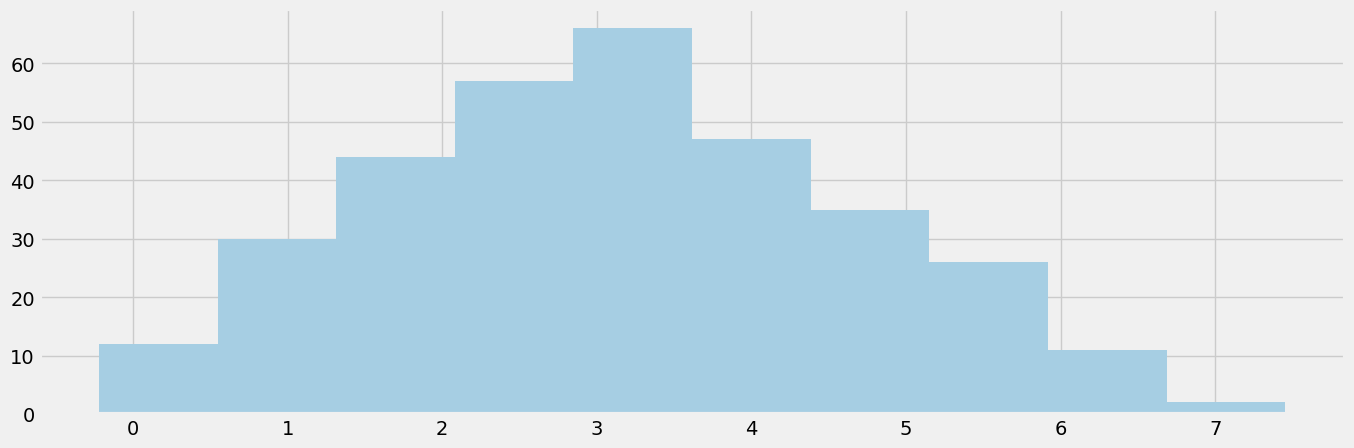

In [23]:
#Show CATE distribution
plt.figure(figsize=(15,5))
plt.hist(base_t_xgb_cate);

In [24]:
#View complete test set
X_complete = (X_test.assign(uplift_scores = base_t_xgb_cate)
              .join(synthetic_uplift['true_uplift']))

In [25]:
X_complete

,treatment,age,last_order_days,loyalty_tier_gold,loyalty_tier_silver,gender_Male,uplift_scores,true_uplift
521,1,26,11,False,False,True,1.369953,1.91
737,1,29,13,True,False,False,2.693130,2.34
740,1,27,28,False,False,True,4.320621,4.47
660,0,26,3,True,False,True,0.531828,0.81
411,1,31,21,True,False,True,3.134103,3.56
...,...,...,...,...,...,...,...,...
506,0,30,5,False,False,True,0.981644,1.05
342,1,25,1,False,False,True,0.715153,0.40
485,1,30,5,True,False,False,0.839881,1.15
711,1,28,24,False,True,True,5.205279,5.28


# Next Best Action Model (RL)

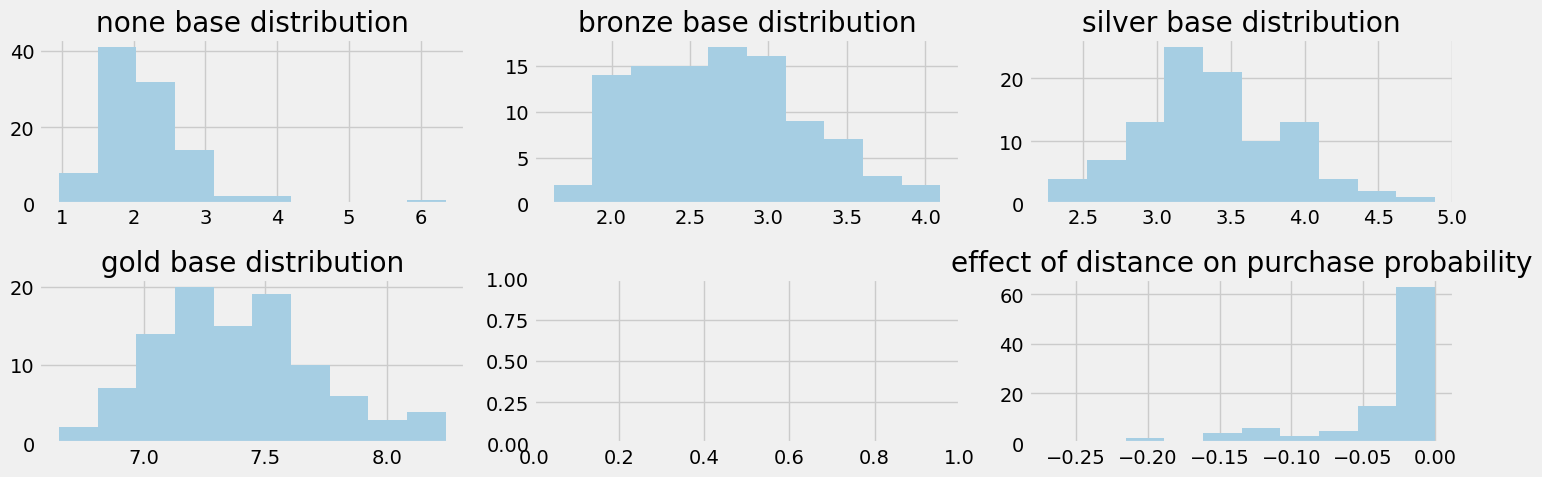

In [26]:
#Plot purchase distribution and effect of distance from store
fig, ax = plt.subplots(2,3, figsize=(15,5))

ax[0,0].hist(np.random.lognormal(.75,.3, 100))
ax[0,0].set_title("none base distribution")

ax[0,1].hist(np.random.lognormal(1,.2, 100))
ax[0,1].set_title("bronze base distribution")

ax[0,2].hist(np.random.lognormal(1.2,.15, 100))
ax[0,2].set_title("silver base distribution")

ax[1,0].hist(np.random.lognormal(2,.05, 100))
ax[1,0].set_title("gold base distribution")

ax[1,2].hist(-np.exp(-1.5 * np.random.lognormal(1, .5, 100)))
ax[1,2].set_title("effect of distance on purchase probability")

fig.tight_layout();

In [27]:
print(np.__version__)

1.24.2


In [28]:
#Define function for incorporating uplift into RL
def calc_uplift(mark_action, tier, channel):
    comp_uplift = {
        'none': {'push': {'ad': .2, 'small discount': .3, 'large discount': 1}, 
                 'text': {'ad': 0, 'small discount': 0, 'large discount': 0}, 
                 'email': {'ad': .1, 'small discount': .2, 'large discount': .75}
                },
        'bronze': {'push': {'ad': .4, 'small discount': .7, 'large discount': 1}, 
                 'text': {'ad': .05, 'small discount': .5, 'large discount': 1}, 
                 'email': {'ad': .2, 'small discount': .6, 'large discount': 1}
                },
        'silver': {'push': {'ad': .4, 'small discount': 1, 'large discount': 2}, 
                 'text': {'ad': .05, 'small discount': .5, 'large discount': 1}, 
                 'email': {'ad': .3, 'small discount': .8, 'large discount': 1.5}
                },
        'gold': {'push': {'ad': -1.5, 'small discount': .2, 'large discount': .2}, 
                 'text': {'ad': -3, 'small discount': 0, 'large discount': 0}, 
                 'email': {'ad': -1.3, 'small discount': .2, 'large discount': .2}
                }
    }
    
    comp_base = {
        'none': np.random.lognormal(.75, .3),
        'bronze': np.random.lognormal(1, .3),
        'silver': np.random.lognormal(1.2, .15),
        'gold': np.random.lognormal(2, .05)
    }
    
    if mark_action == 'none':
        return np.round(comp_base[tier], 2)
    else:
        uplift = comp_uplift[tier][channel][mark_action]
        return np.round(comp_base[tier], 2) + uplift

#Define function for updating loyalty tier (state)
def update_tier(current_tier, purchase):
    tier_transition_purchase = {
        'none': [.7, .3], #prob of staying, prob of going up
        'bronze': [.5, .5], #prob of staying, prob of going up
        'silver': [.5, .5], # prob of staying, prob of going up
        'gold': [1, 0] # prob of staying
    }
    tier_transition_no_purchase = {
        'none': [1, 0], #prob of staying
        'bronze': [.6, .4], #prob of staying, prob of going down
        'silver': [.5, .5], # prob of staying, prob of going down
        'gold': [.8, .2] # prob of staying, prob of doing down
    }
    choices = [0, 1]
    cond_list = [current_tier == 'none', current_tier == 'bronze', current_tier == 'silver', current_tier == 'gold']
    choice_list_up = ['bronze', 'silver', 'gold', 'gold']
    choice_list_down = ['none', 'none', 'bronze', 'silver']
    
    if purchase:
        tier_choice = np.random.choice(choices, p=tier_transition_purchase[current_tier])
        return np.where(tier_choice == 0, current_tier, np.select(cond_list, choice_list_up))
    else:
        tier_choice = np.random.choice(choices, p=tier_transition_no_purchase[current_tier])
        return np.where(tier_choice == 0, current_tier, np.select(cond_list, choice_list_down))
            
    

#Define function for updating probabilities
def update_purchase_probs(dict_probs, p):
    for key, val in dict_probs.items():
        val[-1] += p
        total = sum(val)
        dict_probs[key] = [v / total for v in val]
        
    return dict_probs

#Define function for customer profiles
def generate_rl_cust(n_users=100, n_t=100, random_seed=42):
    np.random.seed(42)
    
    marketing_channels = [
        'push', 
        'text', 
        'email'
    ]
    
    events_cust = [
        0, #None
        1, #Visit
        2  #Purchase
    ]
    
    event_probs_dict = {
        'none': [.7, .25, .05],
        'bronze': [.6, .1, .3],
        'silver': [.4, .1, .5],
        'gold': [.05, .05, .9]
    }
    
    marketing_probs_dict = {
        'none': {'ad': .05, 'small discount': .2, 'large discount': .5},
        'bronze': {'ad': .05, 'small discount': .3, 'large discount': .5},
        'silver': {'ad': .1, 'small discount': .4, 'large discount': .6},
        'gold': {'ad': -.5, 'small discount': 0, 'large discount': 0}
    }
    
    marketing_costs = {
        'none': 0,
        'ad': .75,
        'small discount': 1.5,
        'large discount': 2.5
    }
    
    data_dict = {
        'user_id': [],
        'time_step': [],
        'age': [],
        'gender': [],
        'loyalty_tier': [],
        'event': [],
        'ticket_size': [],
        'distance_store': [],
        'marketing_action': [],
        'marketing_channel':[],
        'marketing_cost': []
    }
    
    for i in range(1, n_users+1):
        age = 18 + np.random.binomial(30, .3)
        tier = np.random.choice(['none', 'bronze', 'silver', 'gold'], p=[.4, .3, .2, .1])
        gender = np.random.choice(['Male', 'Female'])
        
        for t in range(n_t):
            distance_store = np.round(np.random.lognormal(1, .5), 2)
            channel = np.random.choice(marketing_channels)
            action = np.random.choice([k for k in marketing_costs.keys()], p=[.4, .3, .2, .1])
            cost = marketing_costs[action]
            distance_eff = np.where(-np.exp(-1.5 * distance_store) > .1, -.1, -np.exp(-1.5 * distance_store)).item()
            
            if action == 'none':
                data_dict['marketing_channel'].append('none')
                temp_probs_dict = event_probs_dict.copy()
                temp_probs_dict = update_purchase_probs(temp_probs_dict, distance_eff)
                event = rd.choices(events_cust, temp_probs_dict[tier], k=1)[0]
            else:
                data_dict['marketing_channel'].append(channel)
                temp_probs_dict = event_probs_dict.copy()
                change_probs_purchase = marketing_probs_dict[tier][action]
                temp_probs_dict = update_purchase_probs(temp_probs_dict, change_probs_purchase - distance_eff)
                
                event = rd.choices(events_cust, temp_probs_dict[tier], k=1)[0]
            
            ticket_size = np.where(event == 2, calc_uplift(action, tier, channel), 0).item()
            
            data_dict['user_id'].append(i)
            data_dict['time_step'].append(t)
            data_dict['age'].append(age)
            data_dict['gender'].append(gender)
            data_dict['loyalty_tier'].append(tier)
            data_dict['event'].append(event)
            data_dict['ticket_size'].append(ticket_size)
            data_dict['distance_store'].append(distance_store)
            data_dict['marketing_action'].append(action)
            data_dict['marketing_cost'].append(cost)
            
            tier = np.where(event == 2, update_tier(tier, True), update_tier(tier, False)).item()
            
            
                
    
    X = pd.DataFrame(data_dict)
    
    return X

In [29]:
#Generate data
temp = generate_rl_cust(500, 50)

In [30]:
#View data
temp.shape

(25000, 11)

In [31]:
#Get dummies
temp = pd.get_dummies(temp, columns=['loyalty_tier'], dtype=float)

In [32]:
temp.head()

,user_id,time_step,age,gender,event,ticket_size,distance_store,marketing_action,marketing_channel,marketing_cost,loyalty_tier_bronze,loyalty_tier_gold,loyalty_tier_none,loyalty_tier_silver
0,1,0,26,Male,2,7.22,3.45,none,none,0.00,0.0,1.0,0.0,0.0
1,1,1,26,Male,2,4.51,3.57,ad,text,0.75,0.0,1.0,0.0,0.0
2,1,2,26,Male,1,0.00,5.66,none,none,0.00,0.0,1.0,0.0,0.0
3,1,3,26,Male,1,0.00,4.12,large discount,push,2.50,0.0,1.0,0.0,0.0
4,1,4,26,Male,2,6.90,2.08,none,none,0.00,0.0,1.0,0.0,0.0


In [33]:
#Define Deep Q Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        return self.fc3(x)

In [34]:
#Intialize parameters for DQN
m_actions = ['none', 'ad', 'small discount', 'large discount']
m_channels = ['push', 'text', 'email']
comb_act_channels = ['none'] + [f"{a}-{c}" for a in m_actions[1:] for c in m_channels]

state_size = 8
action_size = len(comb_act_channels)
mod = DQN(state_size, action_size)
optimizer = optim.Adam(mod.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [35]:
comb_act_channels

['none',
 'ad-push',
 'ad-text',
 'ad-email',
 'small discount-push',
 'small discount-text',
 'small discount-email',
 'large discount-push',
 'large discount-text',
 'large discount-email']

In [36]:
#Instantiate DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = mod
        self.optimizer = optimizer
        self.criterion = criterion

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if rd.random() <= self.epsilon:
            return rd.randrange(self.action_size)
        with torch.no_grad():
            act_values = self.model(state.unsqueeze(0))
        return torch.argmax(act_values[0]).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = rd.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.stack(states)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.stack(next_states)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        targets = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.criterion(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()

In [37]:
#Set parameters for training loop
agent = DQNAgent(state_size, action_size)
batch_size = 50
episodes = 10

In [38]:
#Define state function
def get_state(state):
    s_dict = {
        'age': state['age'],
        'gender': np.where(state['gender'] == 'Male', 1, 0).item(),
        'distance_store': state['distance_store'],
        'time_step': state['time_step'],
        'loyalty_tier_none': state['loyalty_tier_none'],
        'loyalty_tier_bronze': state['loyalty_tier_bronze'],
        'loyalty_tier_silver': state['loyalty_tier_silver'],
        'loyalty_tier_gold': state['loyalty_tier_gold']
    }
    
    return torch.tensor(list(s_dict.values()), dtype=torch.float32)

In [39]:
#Define reward funciton
def get_reward(user, i):
    comp_uplift = {
        'none': {'push': {'ad': .2, 'small discount': .3, 'large discount': 1}, 
                 'text': {'ad': 0, 'small discount': 0, 'large discount': 0}, 
                 'email': {'ad': .1, 'small discount': .2, 'large discount': .75}
                },
        'bronze': {'push': {'ad': .4, 'small discount': .7, 'large discount': 1}, 
                 'text': {'ad': .05, 'small discount': .5, 'large discount': 1}, 
                 'email': {'ad': .2, 'small discount': .6, 'large discount': 1}
                },
        'silver': {'push': {'ad': .4, 'small discount': 1, 'large discount': 2}, 
                 'text': {'ad': .05, 'small discount': .5, 'large discount': 1}, 
                 'email': {'ad': .3, 'small discount': .8, 'large discount': 1.5}
                },
        'gold': {'push': {'ad': -1.5, 'small discount': 0, 'large discount': .2}, 
                 'text': {'ad': -3, 'small discount': 0, 'large discount': 0}, 
                 'email': {'ad': -1.3, 'small discount': 0, 'large discount': .2}
                }
    }
    
    eff_reward = 0
    none_bool = False
    
    if user.iloc[i]['marketing_action'] == 'none':
        eff_reward = user.iloc[i]['ticket_size']
        none_bool = True
    else:
        uplift_effect = comp_uplift['none'][user.iloc[i]['marketing_channel']][user.iloc[i]['marketing_action']] * user.iloc[i]['loyalty_tier_none'] 
        + comp_uplift['bronze'][user.iloc[i]['marketing_channel']][user.iloc[i]['marketing_action']] * user.iloc[i]['loyalty_tier_bronze'] 
        + comp_uplift['silver'][user.iloc[i]['marketing_channel']][user.iloc[i]['marketing_action']] * user.iloc[i]['loyalty_tier_silver'] 
        + comp_uplift['gold'][user.iloc[i]['marketing_channel']][user.iloc[i]['marketing_action']] * user.iloc[i]['loyalty_tier_gold']
        
        eff_reward = user.iloc[i]['ticket_size'] + uplift_effect - user.iloc[i]['marketing_cost']
    
    if i + 1 < len(user):
        current_tier = np.where(user.iloc[i]['loyalty_tier_none'] == 1, 1, 
                               np.where(user.iloc[i]['loyalty_tier_bronze'] == 1, 2, 
                                       np.where(user.iloc[i]['loyalty_tier_silver'] == 1, 3, 4))).item()
        next_tier = np.where(user.iloc[i+1]['loyalty_tier_none'] == 1, 1, 
                               np.where(user.iloc[i+1]['loyalty_tier_bronze'] == 1, 2, 
                                       np.where(user.iloc[i+1]['loyalty_tier_silver'] == 1, 3, 4))).item()
        
        if current_tier == 4 and next_tier == 4:
            if none_bool == True:
                eff_reward += 5
            elif user.iloc[i]['ticket_size'] > 0:
                eff_reward += 2
            else:
                eff_reward -= 5
        elif next_tier > current_tier:
            eff_reward += 3
        elif next_tier < current_tier:
            eff_reward -= 5
        
    return eff_reward
        

In [40]:
#Perform training
actions_per_user = {}
cumulative_reward = []
loss_func = []

for e in range(episodes):
    e_reward = 0
    step_count = 0
    
    for user_id in temp['user_id'].unique():
        user_data = temp[temp['user_id'] == user_id].sort_values(by='time_step')
        state = get_state(user_data.iloc[0])
        a = []

        for i in range(len(user_data) - 1):
            action = agent.act(state)
        
            reward = get_reward(user_data, i)
            #print(f"user_{user_id} reward: {reward}")
            e_reward += reward

            next_state = get_state(user_data.iloc[i + 1])
            done = (i == len(user_data) - 2)

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            a.append(comb_act_channels[action])
            
            step_count += 1

        if len(agent.memory) > batch_size and step_count % 50 == 0:
            loss = agent.replay(batch_size)
            loss_func.append(loss)
        
        if user_id == 1:
            actions_per_user[user_id] = a
        #print(f"cumulative_reward: {e_reward}")
    
    cumulative_reward.append(e_reward)

    print(f"Episode: {e + 1}/{episodes}, Epsilon: {agent.epsilon}")

Episode: 1/10, Epsilon: 0.9511101304657719
Episode: 2/10, Epsilon: 0.9046104802746175
Episode: 3/10, Epsilon: 0.8603841919146962
Episode: 4/10, Epsilon: 0.8183201210226743
Episode: 5/10, Epsilon: 0.778312557068642
Episode: 6/10, Epsilon: 0.7402609576967045
Episode: 7/10, Epsilon: 0.7040696960536299
Episode: 8/10, Epsilon: 0.6696478204705644
Episode: 9/10, Epsilon: 0.6369088258938781
Episode: 10/10, Epsilon: 0.6057704364907278


In [41]:
#View actions by agent for users
actions_per_user[1]

['ad-email',
 'small discount-push',
 'none',
 'small discount-push',
 'ad-text',
 'large discount-push',
 'none',
 'small discount-push',
 'small discount-email',
 'small discount-text',
 'large discount-text',
 'ad-push',
 'small discount-push',
 'ad-push',
 'large discount-text',
 'ad-text',
 'large discount-email',
 'large discount-push',
 'large discount-push',
 'ad-push',
 'small discount-text',
 'ad-push',
 'small discount-push',
 'ad-push',
 'ad-push',
 'small discount-text',
 'large discount-email',
 'large discount-text',
 'small discount-push',
 'large discount-text',
 'ad-text',
 'ad-email',
 'large discount-text',
 'ad-text',
 'large discount-email',
 'none',
 'ad-text',
 'ad-text',
 'small discount-text',
 'none',
 'small discount-push',
 'small discount-push',
 'ad-push',
 'small discount-email',
 'large discount-email',
 'small discount-text',
 'small discount-text',
 'large discount-text',
 'ad-email']

In [42]:
temp.query("user_id == 1")

,user_id,time_step,age,gender,event,ticket_size,distance_store,marketing_action,marketing_channel,marketing_cost,loyalty_tier_bronze,loyalty_tier_gold,loyalty_tier_none,loyalty_tier_silver
0,1,0,26,Male,2,7.22,3.45,none,none,0.00,0.0,1.0,0.0,0.0
1,1,1,26,Male,2,4.51,3.57,ad,text,0.75,0.0,1.0,0.0,0.0
2,1,2,26,Male,1,0.00,5.66,none,none,0.00,0.0,1.0,0.0,0.0
3,1,3,26,Male,1,0.00,4.12,large discount,push,2.50,0.0,1.0,0.0,0.0
4,1,4,26,Male,2,6.90,2.08,none,none,0.00,0.0,1.0,0.0,0.0
5,1,5,26,Male,2,7.28,2.28,small discount,text,1.50,0.0,1.0,0.0,0.0
6,1,6,26,Male,2,7.73,2.16,none,none,0.00,0.0,1.0,0.0,0.0
7,1,7,26,Male,2,7.31,3.96,large discount,push,2.50,0.0,1.0,0.0,0.0
8,1,8,26,Male,1,0.00,1.24,ad,email,0.75,0.0,1.0,0.0,0.0
9,1,9,26,Male,1,0.00,5.87,small discount,push,1.50,0.0,1.0,0.0,0.0


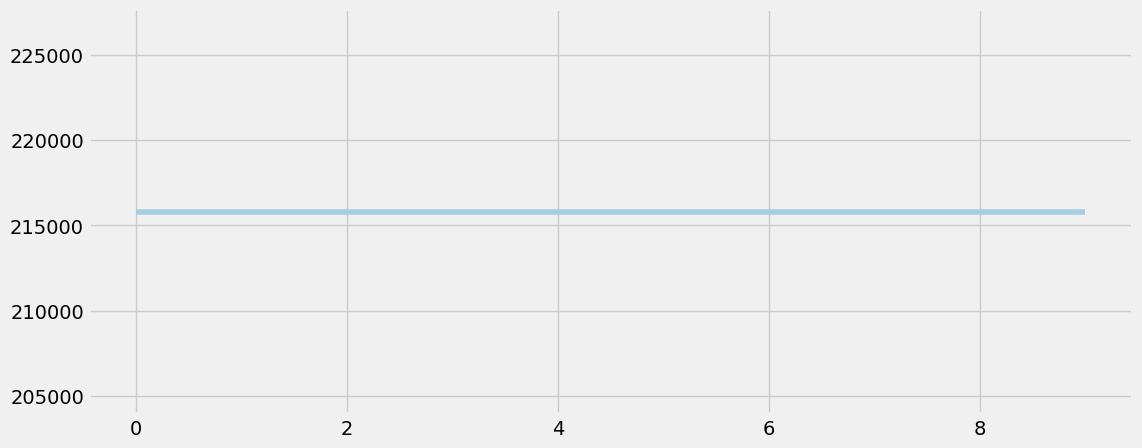

In [43]:
#Plot cumulative rewards
plt.figure(figsize=(12,5))
plt.plot(cumulative_reward);

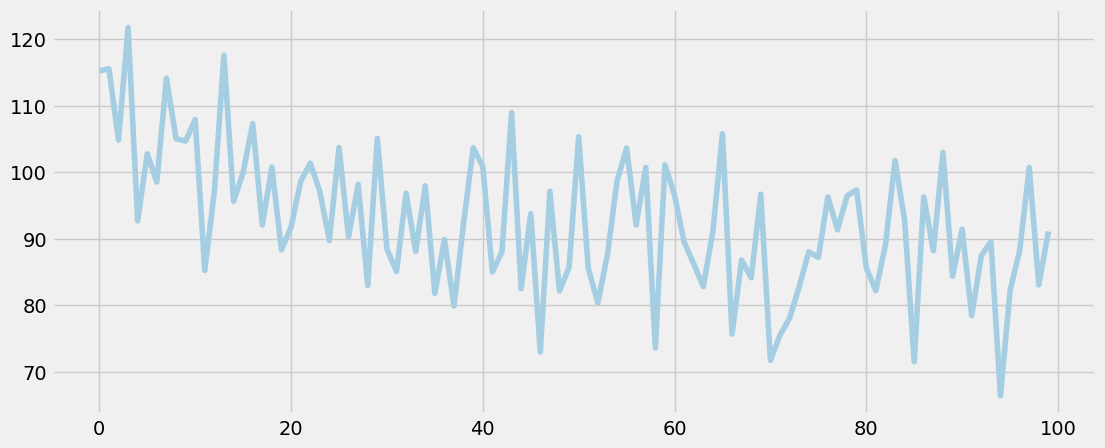

In [44]:
#Plot loss
plt.figure(figsize=(12,5))
plt.plot(loss_func);

In [45]:
#Define test data
test_data = generate_rl_cust(n_users=500, n_t=1)

In [46]:
#Get dummies
test_data = pd.get_dummies(test_data, columns=['loyalty_tier'], dtype=float)

In [47]:
#View data
test_data.head()

,user_id,time_step,age,gender,event,ticket_size,distance_store,marketing_action,marketing_channel,marketing_cost,loyalty_tier_bronze,loyalty_tier_gold,loyalty_tier_none,loyalty_tier_silver
0,1,0,26,Male,2,7.22,3.45,none,none,0.00,0.0,1.0,0.0,0.0
1,2,0,26,Female,0,0.00,3.57,none,none,0.00,1.0,0.0,0.0,0.0
2,3,0,25,Female,1,0.00,4.79,none,none,0.00,1.0,0.0,0.0,0.0
3,4,0,23,Female,2,4.46,6.86,ad,text,0.75,0.0,1.0,0.0,0.0
4,5,0,31,Female,0,0.00,1.73,none,none,0.00,0.0,0.0,0.0,1.0


In [48]:
#Define test function
def test_agent(df, n_t=50, random_seed=42):
    data_dict = {
        'user_id': [],
        'time_step': [],
        'age': [],
        'gender': [],
        'event': [],
        'ticket_size': [],
        'distance_store': [],
        'marketing_action': [],
        'marketing_channel':[],
        'marketing_cost': [],
        'loyalty_tier_none': [],
        'loyalty_tier_bronze': [],
        'loyalty_tier_silver': [],
        'loyalty_tier_gold': []
    }
    
    marketing_costs = {
        'none': 0,
        'ad': .75,
        'small discount': 1.5,
        'large discount': 2.5
    }
    
    marketing_probs_dict = {
        'none': {'ad': .05, 'small discount': .2, 'large discount': .5},
        'bronze': {'ad': .05, 'small discount': .3, 'large discount': .5},
        'silver': {'ad': .1, 'small discount': .4, 'large discount': .6},
        'gold': {'ad': -.1, 'small discount': 0, 'large discount': 0}
    }
    
    events_cust = [
        0, #None
        1, #Visit
        2  #Purchase
    ]
    
    event_probs_dict = {
        'none': [.7, .25, .05],
        'bronze': [.6, .1, .3],
        'silver': [.4, .1, .5],
        'gold': [.05, .05, .9]
    }
    
    for i in range(len(df)):
        tier = np.where(df.iloc[i]['loyalty_tier_none'] == 1, 'none', 
                            np.where(df.iloc[i]['loyalty_tier_bronze'] == 1, 'bronze', 
                                    np.where(df.iloc[i]['loyalty_tier_silver'] == 1, 'silver', 'gold'))).item()
        for t in range(1, n_t+1):
            distance_store = np.round(np.random.lognormal(1, .5), 2)
            
            state = {
                'age': df.iloc[i]['age'],
                'gender': np.where(df.iloc[i]['gender'] == 'Male', 1, 0).item(),
                'distance_store': distance_store,
                'time_step': t,
                'loyalty_tier_none': 1 if tier == 'none' else 0,
                'loyalty_tier_bronze': 1 if tier == 'bronze' else 0,
                'loyalty_tier_silver': 1 if tier == 'silver' else 0,
                'loyalty_tier_gold': 1 if tier == 'gold' else 0
            }
            
            current_state = get_state(state)
            
            with torch.no_grad():
                agent.model.eval()
                action_test = agent.model(current_state).argmax().item()
                agent.model.train()

            
            distance_eff = np.where(-np.exp(-1.5 * distance_store) > .1, -.1, -np.exp(-1.5 * distance_store)).item()
            action_name = comb_act_channels[action_test]

            if action_name == 'none':
                action_channel = 'none'
                cost = marketing_costs[action_name]
                data_dict['marketing_channel'].append(action_channel)
                temp_probs_dict = event_probs_dict.copy()
                temp_probs_dict = update_purchase_probs(temp_probs_dict, distance_eff)
                event = rd.choices(events_cust, temp_probs_dict[tier], k=1)[0]
            else:
                action_name, action_channel = comb_act_channels[action_test].split("-")
                cost = marketing_costs[action_name]
                data_dict['marketing_channel'].append(action_channel)
                temp_probs_dict = event_probs_dict.copy()
                change_probs_purchase = marketing_probs_dict[tier][action_name]
                temp_probs_dict = update_purchase_probs(temp_probs_dict, change_probs_purchase - distance_eff)
                event = rd.choices(events_cust, temp_probs_dict[tier], k=1)[0]

            ticket_size = np.where(event == 2, calc_uplift(action_name, tier, action_channel), 0).item()

            data_dict['user_id'].append(i+1)
            data_dict['time_step'].append(t)
            data_dict['age'].append(df.iloc[i]['age'])
            data_dict['gender'].append(df.iloc[i]['gender'])
            data_dict['event'].append(event)
            data_dict['ticket_size'].append(ticket_size)
            data_dict['distance_store'].append(distance_store)
            data_dict['marketing_action'].append(action_name)
            data_dict['marketing_cost'].append(cost)
            data_dict['loyalty_tier_none'].append(1 if tier == 'none' else 0)
            data_dict['loyalty_tier_bronze'].append(1 if tier == 'bronze' else 0)
            data_dict['loyalty_tier_silver'].append(1 if tier == 'silver' else 0)
            data_dict['loyalty_tier_gold'].append(1 if tier == 'gold' else 0)
            
            tier = np.where(event == 2, update_tier(tier, True), update_tier(tier, False)).item()
        
    return pd.DataFrame(data_dict)

In [49]:
#Get results
res_test = test_agent(test_data)

In [50]:
#Show actions for user 1
res_test.query("user_id == 2")

,user_id,time_step,age,gender,event,ticket_size,distance_store,marketing_action,marketing_channel,marketing_cost,loyalty_tier_none,loyalty_tier_bronze,loyalty_tier_silver,loyalty_tier_gold
50,2,1,26,Female,2,2.93,1.85,small discount,push,1.50,0,1,0,0
51,2,2,26,Female,2,4.50,1.76,small discount,push,1.50,0,0,1,0
52,2,3,26,Female,2,7.82,3.52,small discount,push,1.50,0,0,0,1
53,2,4,26,Female,2,7.91,0.96,none,none,0.00,0,0,0,1
54,2,5,26,Female,2,7.34,4.76,small discount,push,1.50,0,0,0,1
55,2,6,26,Female,2,7.24,5.45,small discount,push,1.50,0,0,0,1
56,2,7,26,Female,2,7.76,1.80,none,none,0.00,0,0,0,1
57,2,8,26,Female,2,7.15,1.87,none,none,0.00,0,0,0,1
58,2,9,26,Female,2,7.83,2.48,large discount,push,2.50,0,0,0,1
59,2,10,26,Female,2,8.02,2.85,large discount,push,2.50,0,0,0,1


In [62]:
#SHow counts of tiers after 
(res_test.groupby('user_id')
 .tail(1)[['loyalty_tier_none', 'loyalty_tier_bronze', 'loyalty_tier_silver', 'loyalty_tier_gold']]
 .sum(axis=1).sum())

500

In [63]:
#Show counts
(res_test.groupby('user_id')
 .tail(1)[['loyalty_tier_none', 'loyalty_tier_bronze', 'loyalty_tier_silver', 'loyalty_tier_gold']]
 .sum())

loyalty_tier_none        0
loyalty_tier_bronze      0
loyalty_tier_silver      1
loyalty_tier_gold      499
dtype: int64

In [52]:
#TODO: CHANGE REWARD STRUCTURE TO KEEP ACTIONS TO GOLD TIER AT A MINIMUM
# HIERARCHICAL LOGIG TO UPDATING MARKETING PROBS BASED ON CHANNEL AS WELL